In [25]:
#Load libraries 

library(Seurat)
library(patchwork)
library(dplyr)
library(harmony)
library(DoubletFinder)
library(tidyverse)
library(ggpubr)
library(scDblFinder)
library(foreach)
library(doParallel)
library(BiocParallel)
library(SeuratDisk)
library(future)
library(scater)
library(SoupX)
library(celldex)
library(SingleR)
library(dittoSeq)
library(presto)
library(scCustomize)
library(viridis)
library(Nebulosa)
library(liana)
library(Seurat)
library(ggplot2)
library(patchwork)
library(Matrix)
library(SeuratData)
library(tidyverse)
library(RColorBrewer)
library(ggpubr)
library(scDataviz)
library(hexbin)
library(ggplot.multistats)
library(AUCell)
library(doMC)
library(SCpubr)
library(tidyverse)
library(magrittr)
library(liana)
library(furrr)
library(DT)
library(nichenetr)
library(ggrepel)
library(cowplot)
options(timeout=300) # required to download expression data /w slow connection
library(msigdbr)

In [2]:
##Load dataset 

setwd("/home/vshanmug/results/091122_detailed_single_nuc_Hodgkin_annotation_exploration/")

combined_dataset_final <- LoadH5Seurat("combined_dataset_final_annotated_postqc_harmonized1.h5Seurat")

Validating h5Seurat file

Initializing cellbender_corrected with data

Adding counts for cellbender_corrected

Adding feature-level metadata for cellbender_corrected

Adding variable feature information for cellbender_corrected

Adding miscellaneous information for cellbender_corrected

Adding reduction harmony

Adding cell embeddings for harmony

Adding feature loadings for harmony

Adding projected loadings for harmony

Adding miscellaneous information for harmony

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



## Ligand-receptor interaction analysis with LIANA

In [6]:
## Subset dataset to only HL samples 

HL_dataset <- subset(combined_dataset_final, subset = condition == "HL")

## Run LIANA
HL_liana_results_expr_prop_0.05 <- liana_wrap(
    sce = HL_dataset, idents_col = "cell_types_level_3",  
    resource='custom', external_resource = select_resource("Consensus")[[1]] %>% liana:::decomplexify(),
    expr_prop = 0.05, parallelize = TRUE, workers = 8
)

setwd("/home/vshanmug/results/091122_detailed_single_nuc_Hodgkin_annotation_exploration/")
saveRDS(HL_liana_results_expr_prop_0.05, "HL_liana_results_expr_prop_0.05_without_complexes.rds")

HL_liana_results_expr_prop_0.05 <- HL_liana_results_expr_prop_0.05 %>% liana_aggregate()

HL_liana_results_expr_prop_0.05 %>% dplyr::glimpse()

##Save aggregated results as csv

write.csv(HL_liana_results_expr_prop_0.05, "HL_liana_results_expr_prop_0.05_without_complexes.csv")

Expression from the `cellbender_corrected` assay will be used

Running LIANA with `cell_types_level_3` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
“256 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once per session.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.1 GiB”
Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb



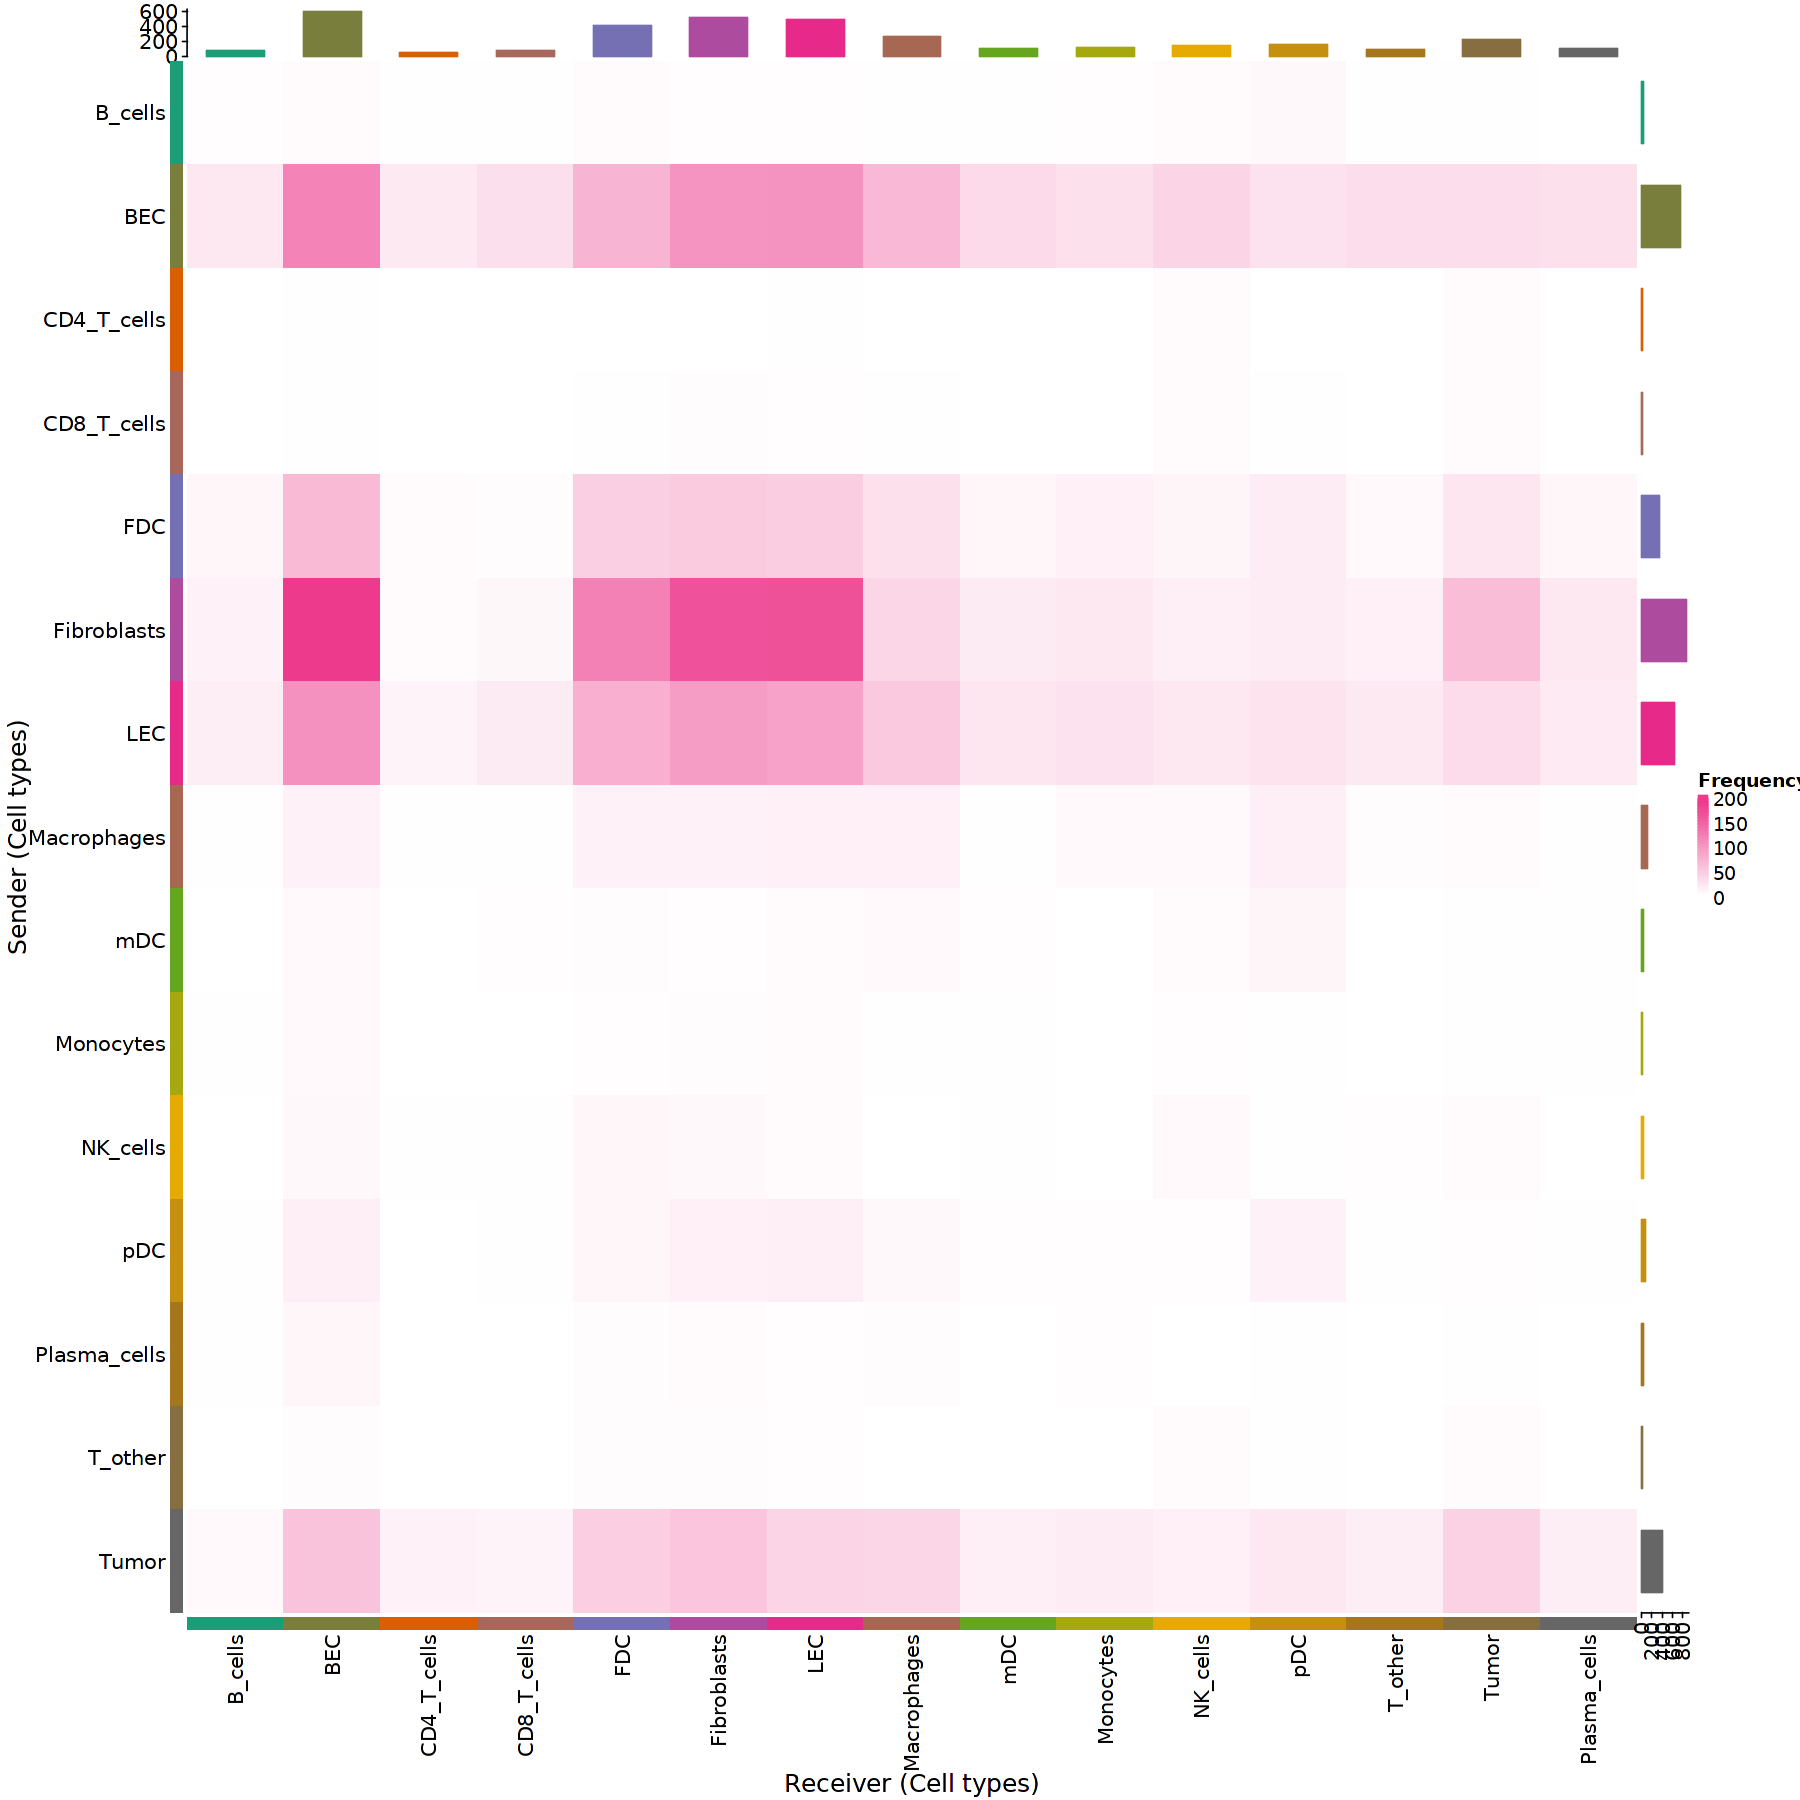

In [6]:
options(repr.plot.width=15, repr.plot.height=15)
liana_trunc <- HL_liana_results %>%
   # only keep interactions concordant between methods
  filter(aggregate_rank <= 0.01) # this can be FDR-corr if n is too high

heat_freq(liana_trunc)

## Combine LIANA results with spatial colocalization analysis results 

In [2]:
setwd("/home/vshanmug/results/091122_detailed_single_nuc_Hodgkin_annotation_exploration/")

## Load merged dataframe 

LR_results <- read.csv("HL_liana_05_single_final.csv")
str(LR_results)

'data.frame':	85028 obs. of  26 variables:
 $ source                : chr  "BEC" "Fibroblasts" "Fibroblasts" "BEC" ...
 $ target                : chr  "pDC" "LEC" "LEC" "LEC" ...
 $ ligand.complex        : chr  "HSPG2" "COL1A1" "COL1A2" "VWF" ...
 $ receptor.complex      : chr  "PTPRS" "CD36" "CD36" "ITGA9" ...
 $ aggregate_rank        : num  5.21e-12 9.07e-12 2.16e-11 5.81e-11 1.78e-10 ...
 $ mean_rank             : num  43.2 34.8 35 29.2 65.6 ...
 $ natmi.edge_specificity: num  0.294 0.442 0.403 0.372 0.338 ...
 $ natmi.rank            : int  207 66 82 105 139 305 730 106 633 169 ...
 $ connectome.weight_sc  : num  5.74 4.19 4.31 6.2 3.81 ...
 $ connectome.rank       : int  3 47 37 2 124 245 62 159 868 203 ...
 $ logfc.logfc_comb      : num  3.72 3.74 3.64 3.58 3.53 ...
 $ logfc.rank            : int  4 3 8 12 14 49 36 10 612 28 ...
 $ sca.LRscore           : num  0.959 0.95 0.951 0.954 0.951 ...
 $ sca.rank              : int  1 57 47 26 50 169 128 60 543 30 ...
 $ cellphonedb.pvalu

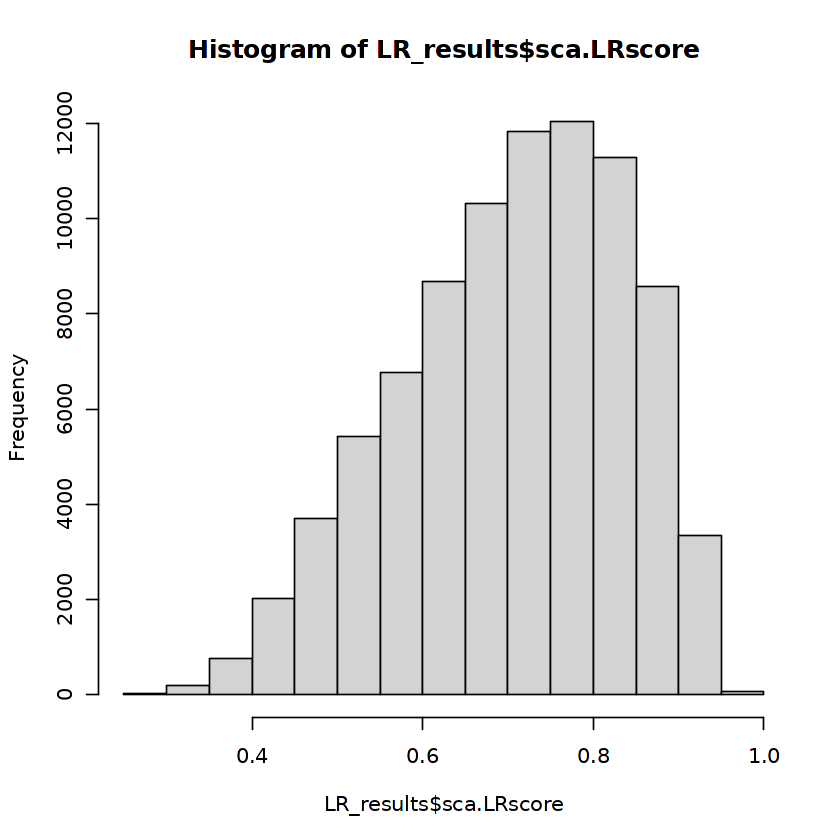

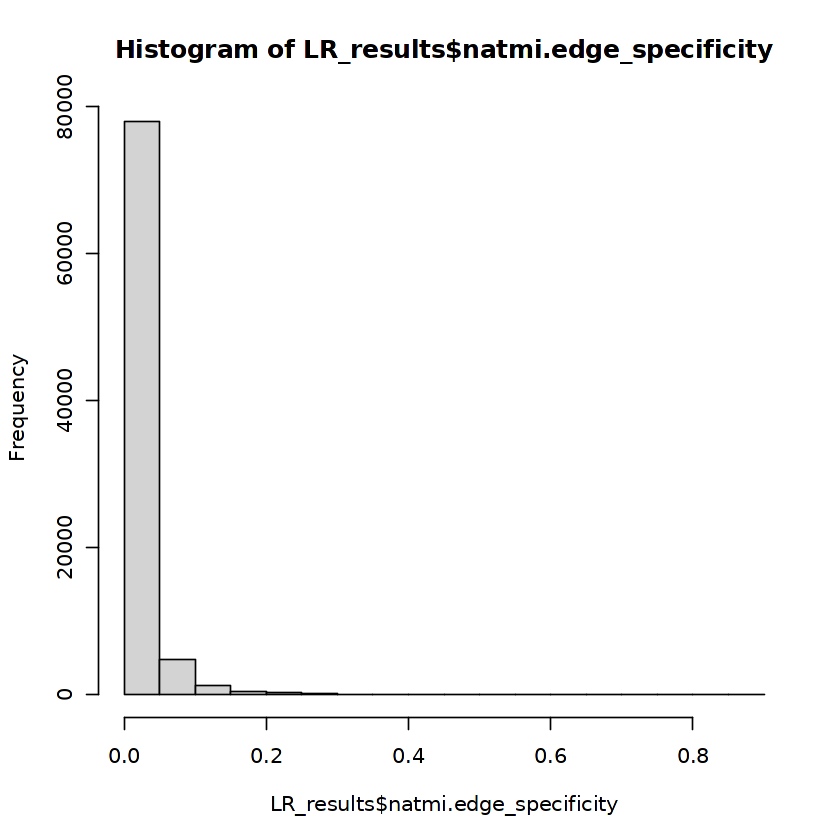

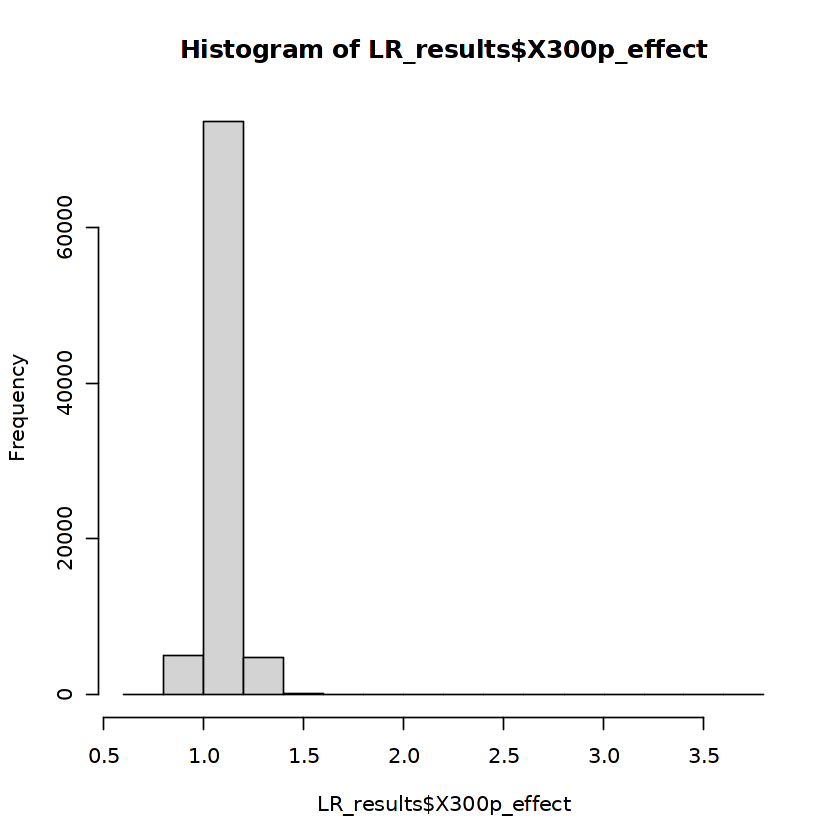

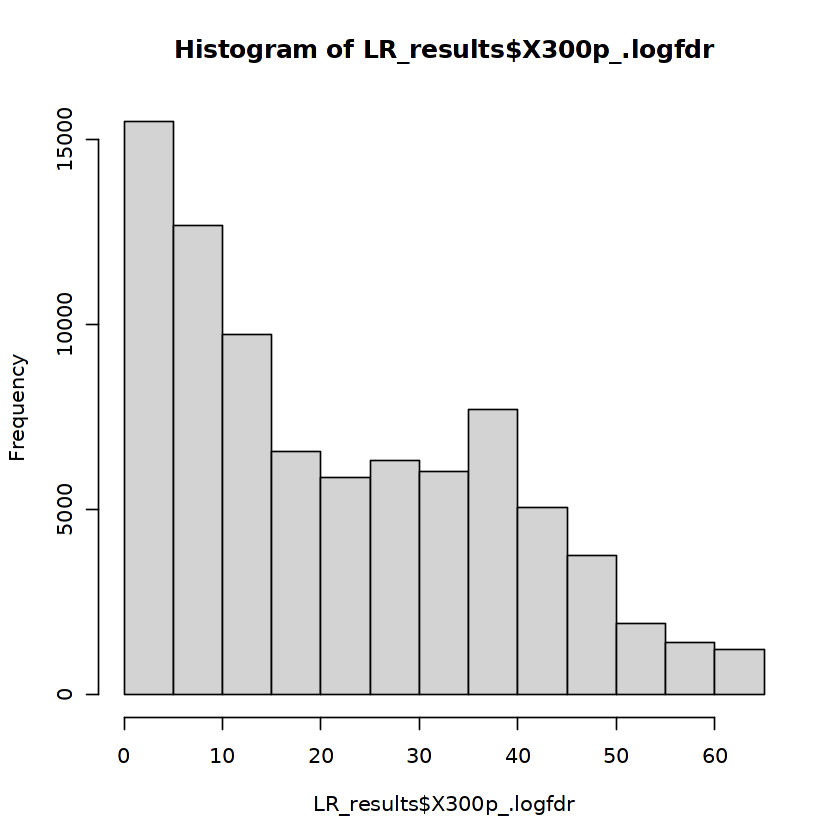

In [3]:
##Plot pvalues and effect sizes to decide on thresholds

hist(LR_results$sca.LRscore)
hist(LR_results$sca.LRscore)
hist(LR_results$natmi.edge_specificity)

hist(LR_results$X300p_effect)
hist(LR_results$X300p_.logfdr)

In [4]:

LR_results_filtered <- LR_results %>% filter(target == "Tumor", X300p_.logfdr > 15, sca.LRscore > 0.4, natmi.edge_specificity > 0.01, X300p_effect > 1) %>% arrange(desc(X300p_effect))

datatable(LR_results_filtered)
dim(LR_results_filtered)


Attaching package: ‘DT’


The following object is masked from ‘package:SeuratObject’:

    JS


The following object is masked from ‘package:Seurat’:

    JS




HTML widgets cannot be represented in plain text (need html)

[1] 809  26

In [6]:
## Number of unique L-R pairs after filtering

LR_results_filtered %>% select(LR) %>% pull() %>% unique() %>% length()

[1] 262

## Run nichenet analysis

In [11]:
# model weights
setwd("/home/vshanmug/results/091122_detailed_single_nuc_Hodgkin_annotation_exploration/")

ligand_target_matrix <- readRDS("ligand_target_matrix.rds")
# target genes in rows, ligands in columns
ligand_target_matrix[1:5,1:5]


CXCL1        CXCL2        CXCL3        CXCL5        PPBP        
A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04
A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04
A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04
A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04
A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05

In [12]:
#Load relevant signature TNFA signaling via NF-kB

##NFKB signature
h_gene_sets = msigdbr(species = "Homo sapiens", category = "H")
nfkb_signature <- h_gene_sets %>% filter(gs_name == "HALLMARK_TNFA_SIGNALING_VIA_NFKB") %>% select(human_gene_symbol) %>% pull() %>% .[. %in% rownames(ligand_target_matrix)]

# STAT6 signatures
C4_CGN_gene_sets = msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CGN")
stat6_cgn_signature <- C4_CGN_gene_sets %>% filter(gs_name == "GNF2_STAT6") %>% select(human_gene_symbol) %>% pull() %>% .[. %in% rownames(ligand_target_matrix)]

C3_TFT_gene_sets = msigdbr(species = "Homo sapiens", category = "C3", subcategory = "TFT:TFT_Legacy")
stat6_01_signature <- C3_TFT_gene_sets %>% filter(gs_name == "STAT6_01") %>% select(human_gene_symbol) %>% pull() %>% .[. %in% rownames(ligand_target_matrix)]

stat6_02_signature <- C3_TFT_gene_sets %>% filter(gs_name == "STAT6_02") %>% select(human_gene_symbol) %>% pull() %>% .[. %in% rownames(ligand_target_matrix)]

In [ ]:
colnames(LR_results_filtered)[3] <- "ligand"
colnames(LR_results_filtered)[4] <- "receptor"

LR_results_filtered <- LR_results_filtered %>% mutate(id = fct_inorder(paste0(ligand, " -> ", receptor)))

# get ligands and filter to those included in NicheNet's ligand-target matrix
ligands <- unique(LR_results_filtered$ligand)
ligands <- ligands[ligands %in% colnames(ligand_target_matrix)]
ligands
length(ligands)

#Total number of prioritized ligands
length(unique(LR_results_filtered$ligand))

##98 of 159 total ligands are in the nichenet database 

In [ ]:
##Generate background gene set 

expressed_genes_receiver = get_expressed_genes(ident = "Tumor", seurat_obj = combined_dataset_final, pct = 0.10, assay_oi = "cellbender_corrected")

background_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]

In [ ]:
##Run nichenet using all signatures sets 

nichenet_activities_nfkb_signature <- predict_ligand_activities(
  geneset = nfkb_signature,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)

nichenet_activities_stat6_cgn_signature <- predict_ligand_activities(
  geneset = stat6_cgn_signature,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)

nichenet_activities_stat6_01_signature <- predict_ligand_activities(
  geneset = stat6_01_signature,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)

nichenet_activities_stat6_02_signature <- predict_ligand_activities(
  geneset = stat6_02_signature,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)


In [38]:
##Combine results into one dataframe
nichenet_activities_nfkb_signature <- nichenet_activities_nfkb_signature %>% mutate(signature = "nfkb_signature") %>% mutate(rank = rank(-pearson))
nichenet_activities_stat6_cgn_signature <- nichenet_activities_stat6_cgn_signature %>% mutate(signature = "stat6_cgn_signature") %>% mutate(rank = rank(-pearson))
nichenet_activities_stat6_01_signature <- nichenet_activities_stat6_01_signature %>% mutate(signature = "stat6_01") %>% mutate(rank = rank(-pearson))
nichenet_activities_stat6_02_signature <- nichenet_activities_stat6_02_signature %>% mutate(signature = "stat6_02") %>% mutate(rank = rank(-pearson))


combined_nichenet_activities <- bind_rows(nichenet_activities_nfkb_signature, nichenet_activities_stat6_cgn_signature, nichenet_activities_stat6_01_signature, nichenet_activities_stat6_02_signature)
datatable(combined_nichenet_activities)


HTML widgets cannot be represented in plain text (need html)

In [39]:
##Add nichenet results back to filtered LR results 

LR_results_filtered_nichenet <- LR_results_filtered %>% left_join(combined_nichenet_activities, by = c("ligand" = "test_ligand"))

datatable(LR_results_filtered_nichenet)

write.csv(LR_results_filtered_nichenet, "LR_results_filtered_nichenet_final.csv")

HTML widgets cannot be represented in plain text (need html)

In [53]:
## Add cluster-specific LR expression information 

HL_liana_results_with_expr <- readRDS("HL_liana_results_expr_prop_0.05_without_complexes.rds")

HL_liana_results_with_expr_cpdb <- HL_liana_results_with_expr$cellphonedb


In [ ]:
LR_results_filtered_nichenet_with_expr <- LR_results_filtered_nichenet %>% left_join(select(HL_liana_results_with_expr_cpdb, c(ligand, receptor, source, target, receptor.prop, ligand.prop, ligand.expr, receptor.expr, lr.mean)), by = c("ligand", "receptor", "source", "target")) %>% rename("lr.mean" = "lr.mean.cpdb")

## Save final prioritized dataframe
write.csv(LR_results_filtered_nichenet_with_expr, "LR_results_filtered_nichenet_final.csv")

## Label transfer analysis of myeloid cells

In [6]:
## Label transfer of monomacs onto mulder reference dataset using Seurat
setwd("/home/vshanmug/results/080622_single_nuc_Hodgkin_annotation/")

combined_myeloid_cells <- LoadH5Seurat("combined_myeloid_cells_fine.h5seurat")

#Load ginhoux dataset

setwd('/home/vshanmug/data/')

ginhoux_dataset <- readRDS('ginhoux_monomac_verse/2021_MoMac_Verse.RDS')


Validating h5Seurat file

Initializing cellbender_corrected with data



In [5]:
DefaultAssay(ginhoux_dataset) <- "integrated"

anchors <- FindTransferAnchors(reference = ginhoux_dataset, query = combined_myeloid_cells,  dims = 1:50, reference.reduction = "pca")


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2710 anchors

Filtering anchors

	Retained 634 anchors



In [6]:
#Run anchor transfer algorithm - Seurat V3 CCA method 
predictions <- TransferData(anchorset = anchors, refdata = ginhoux_dataset$Clusters,
    dims = 1:50)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [7]:
#Add predictions including scores as metadata to myeloid cells object 
combined_myeloid_cells <- AddMetaData(combined_myeloid_cells, metadata = predictions)

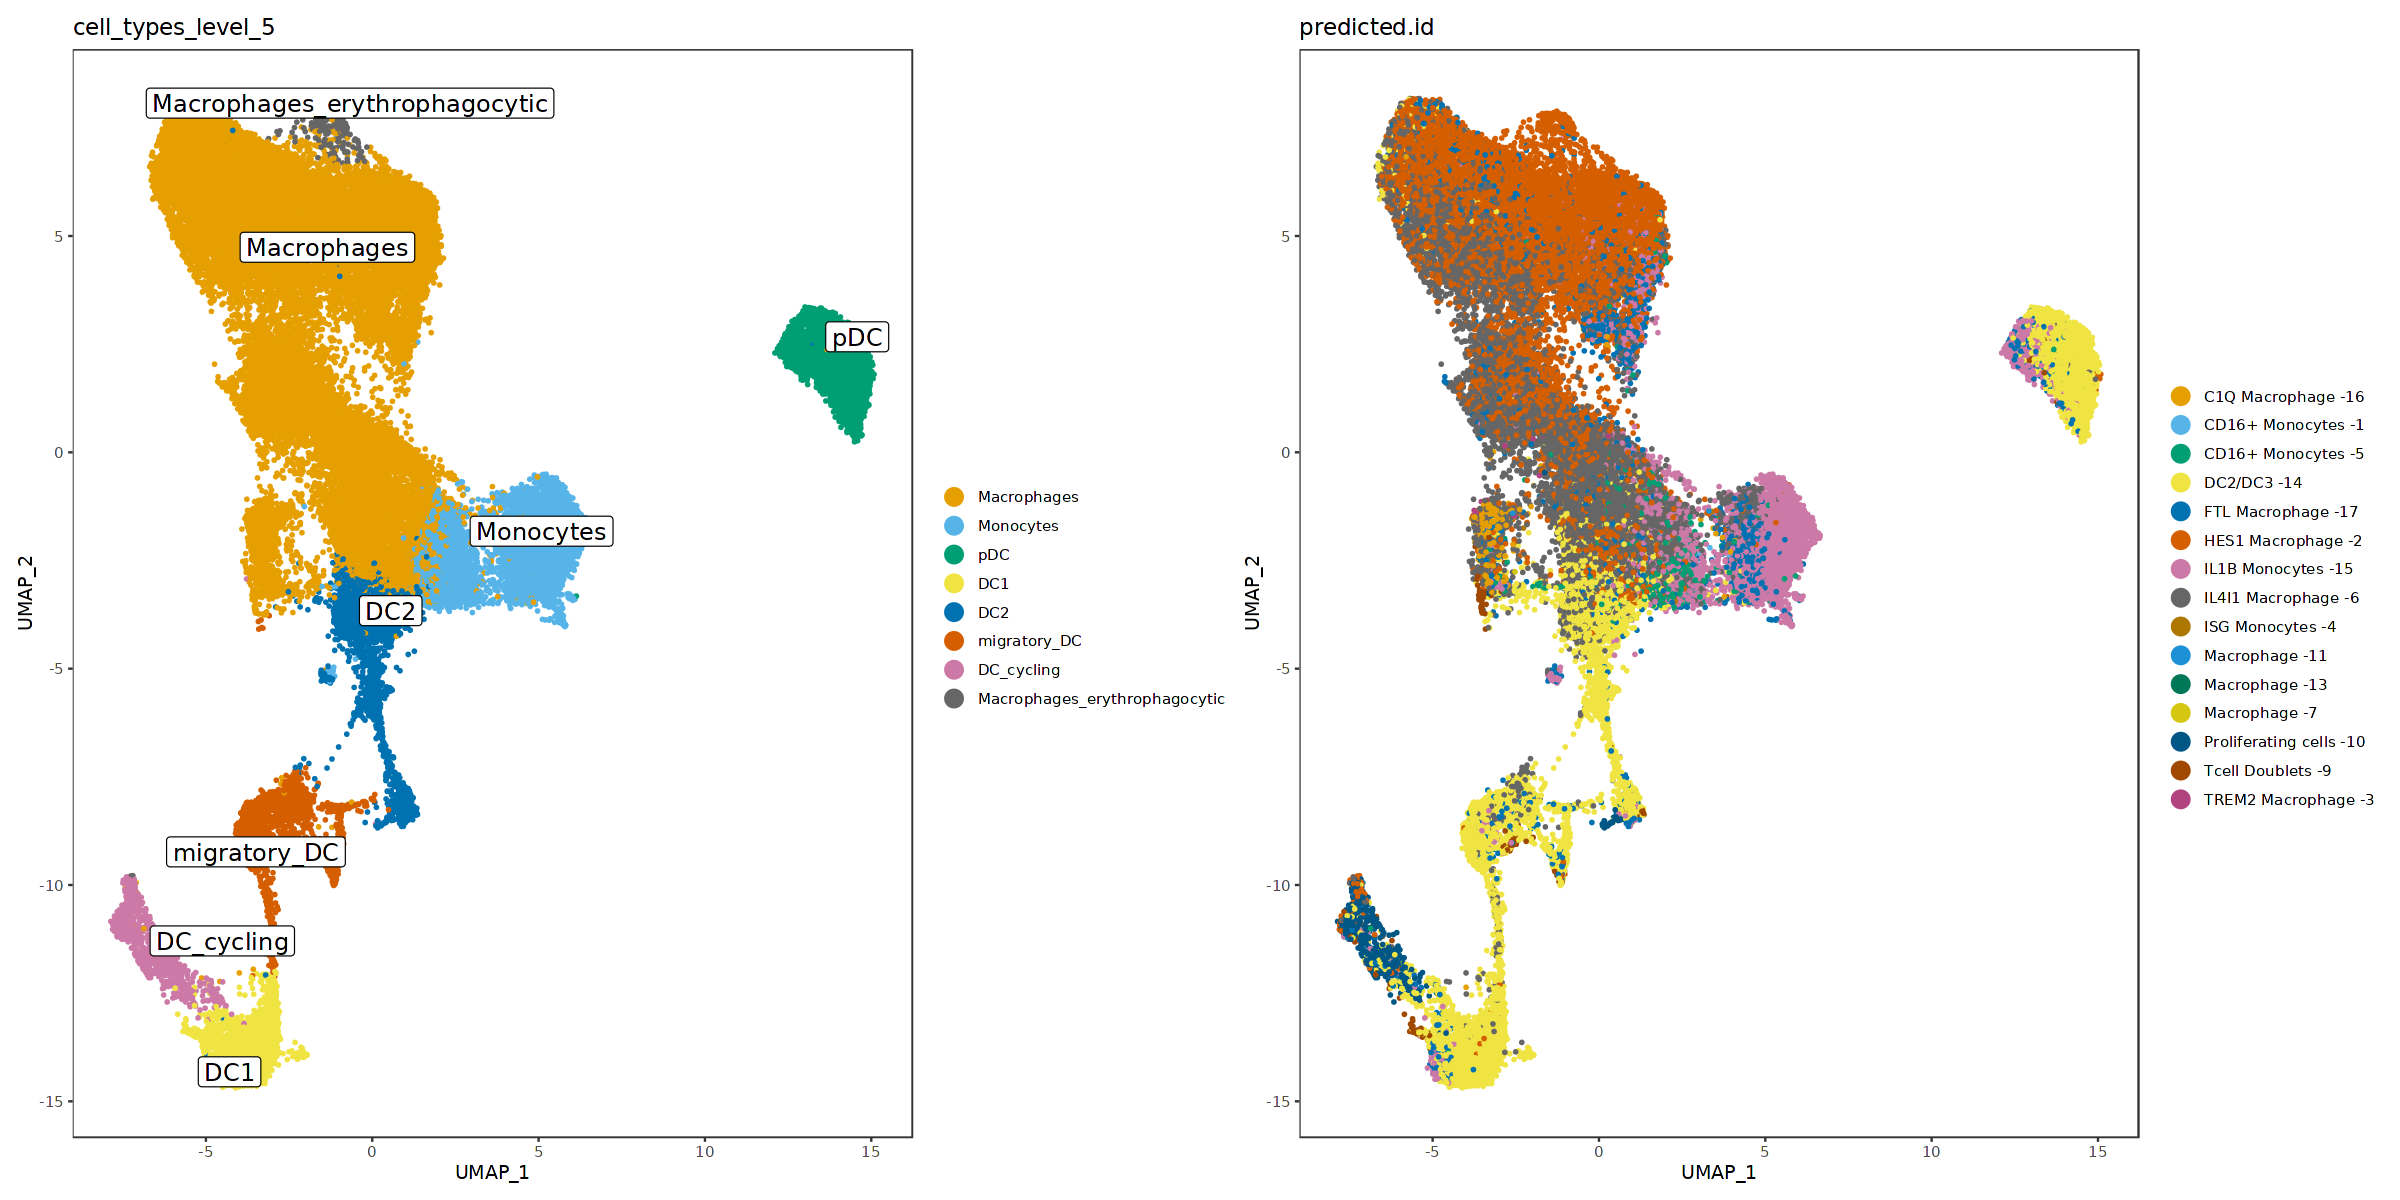

In [21]:
options(repr.plot.width=20, repr.plot.height=10)
p1 <- dittoDimPlot(object = combined_myeloid_cells, var = "cell_types_level_5", do.label = TRUE) 
p2 <- dittoDimPlot(object = combined_myeloid_cells, var = "predicted.id")
p1 + p2

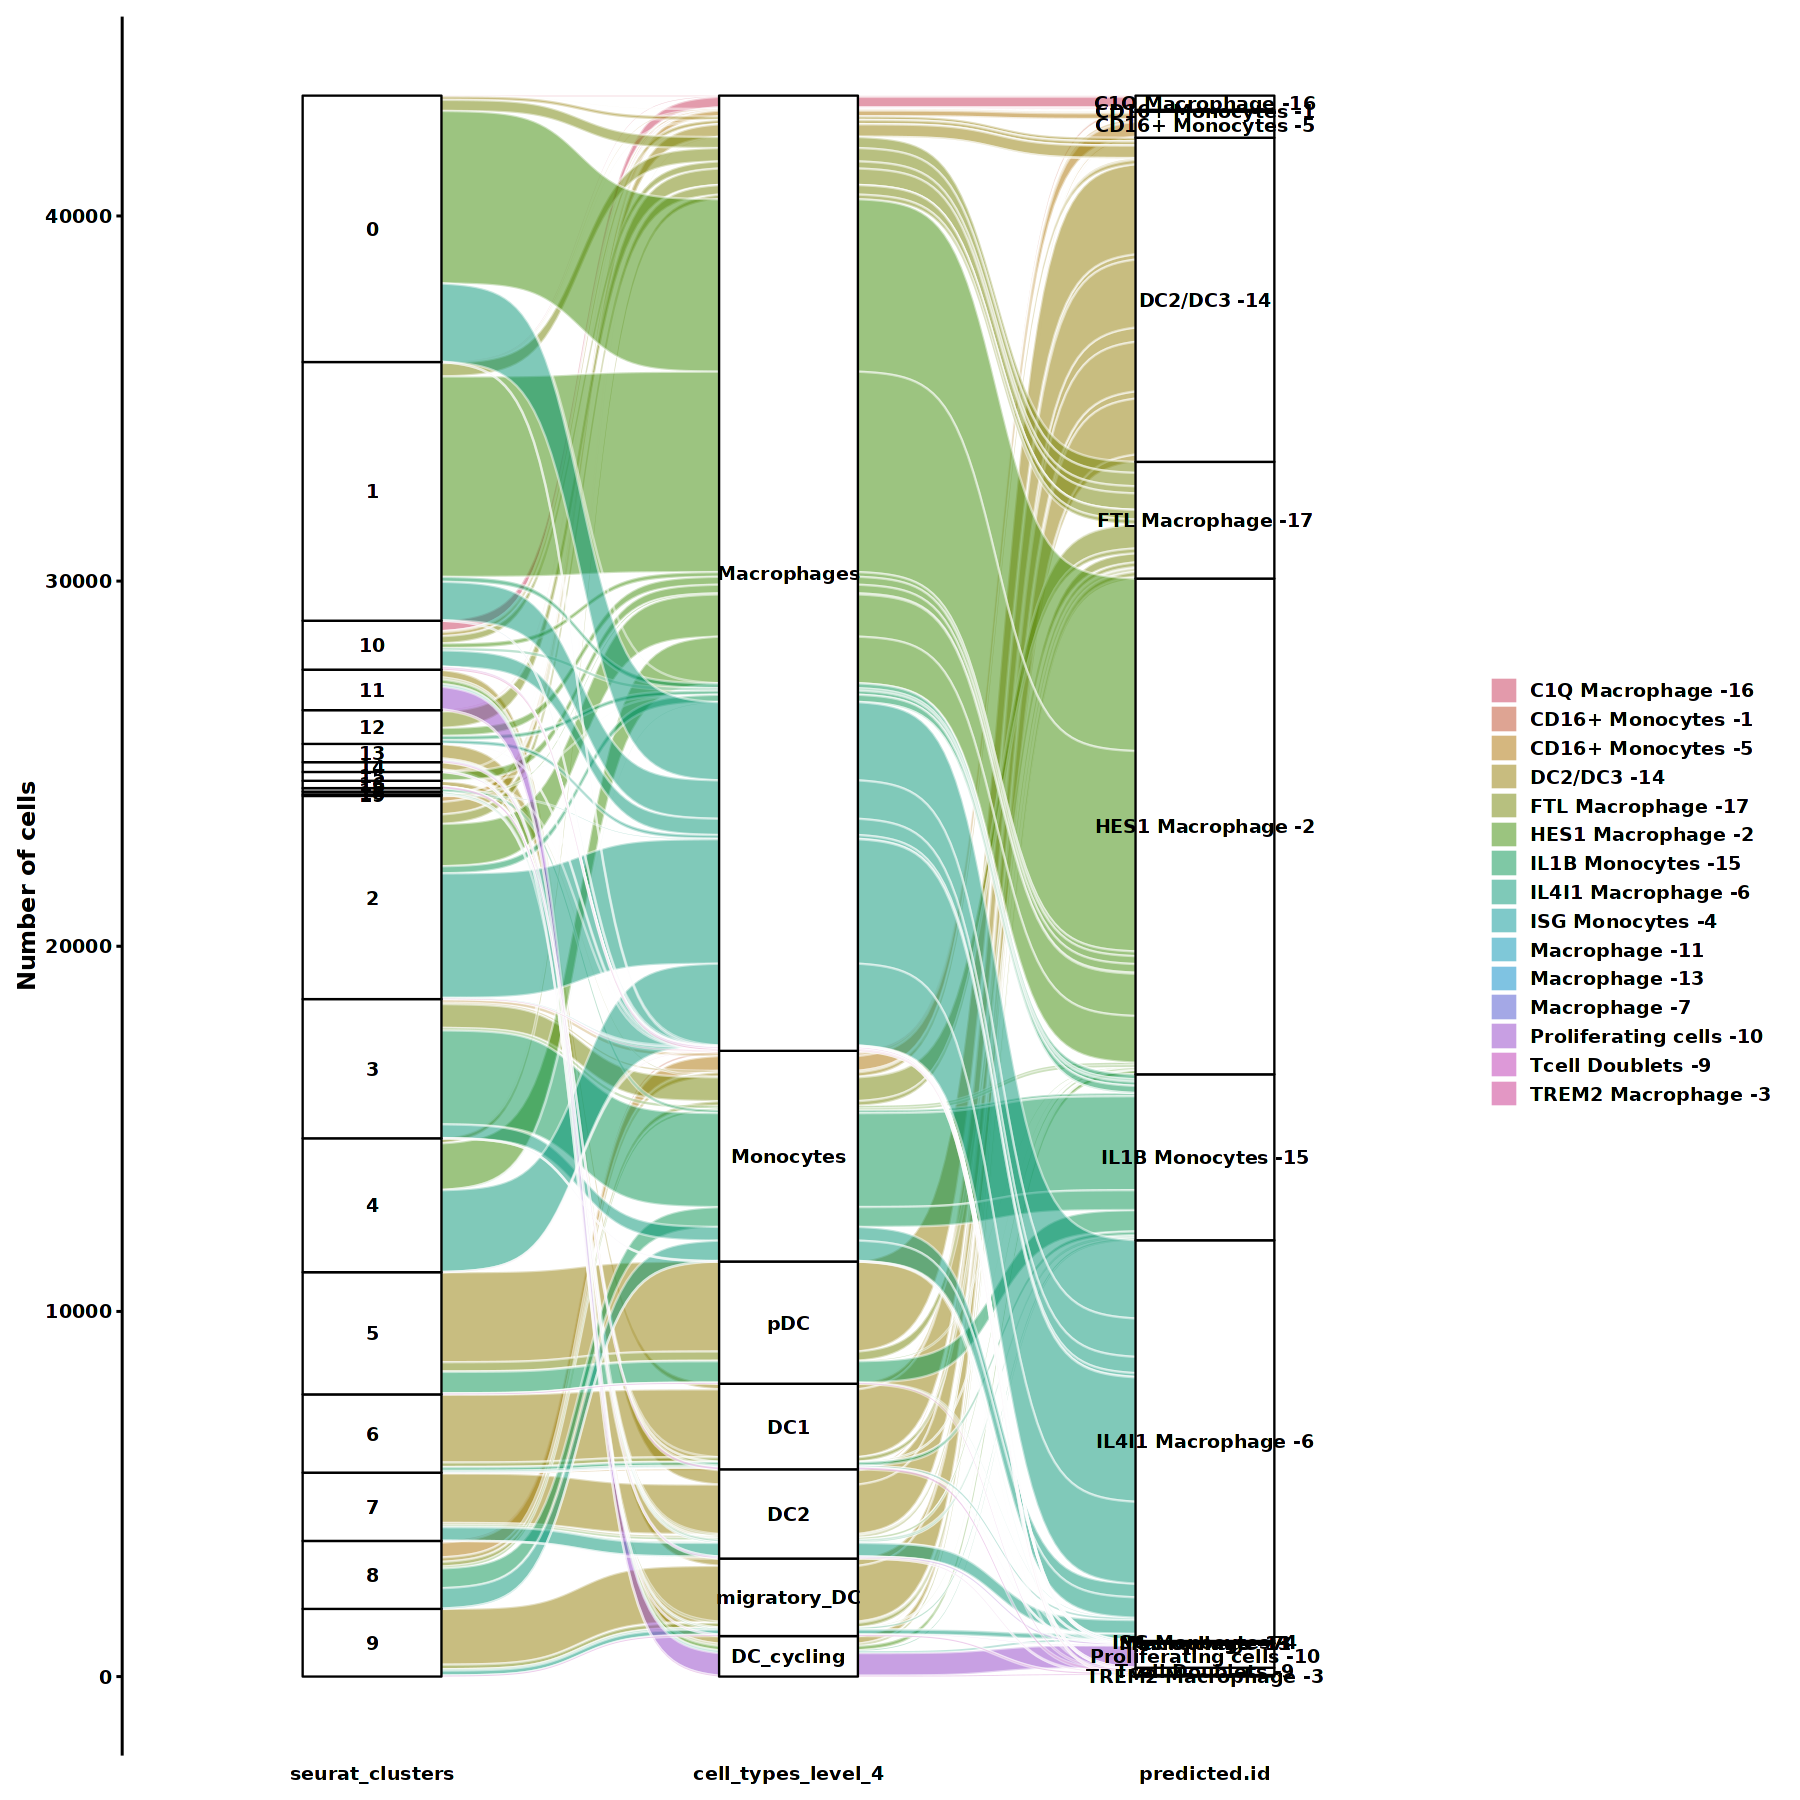

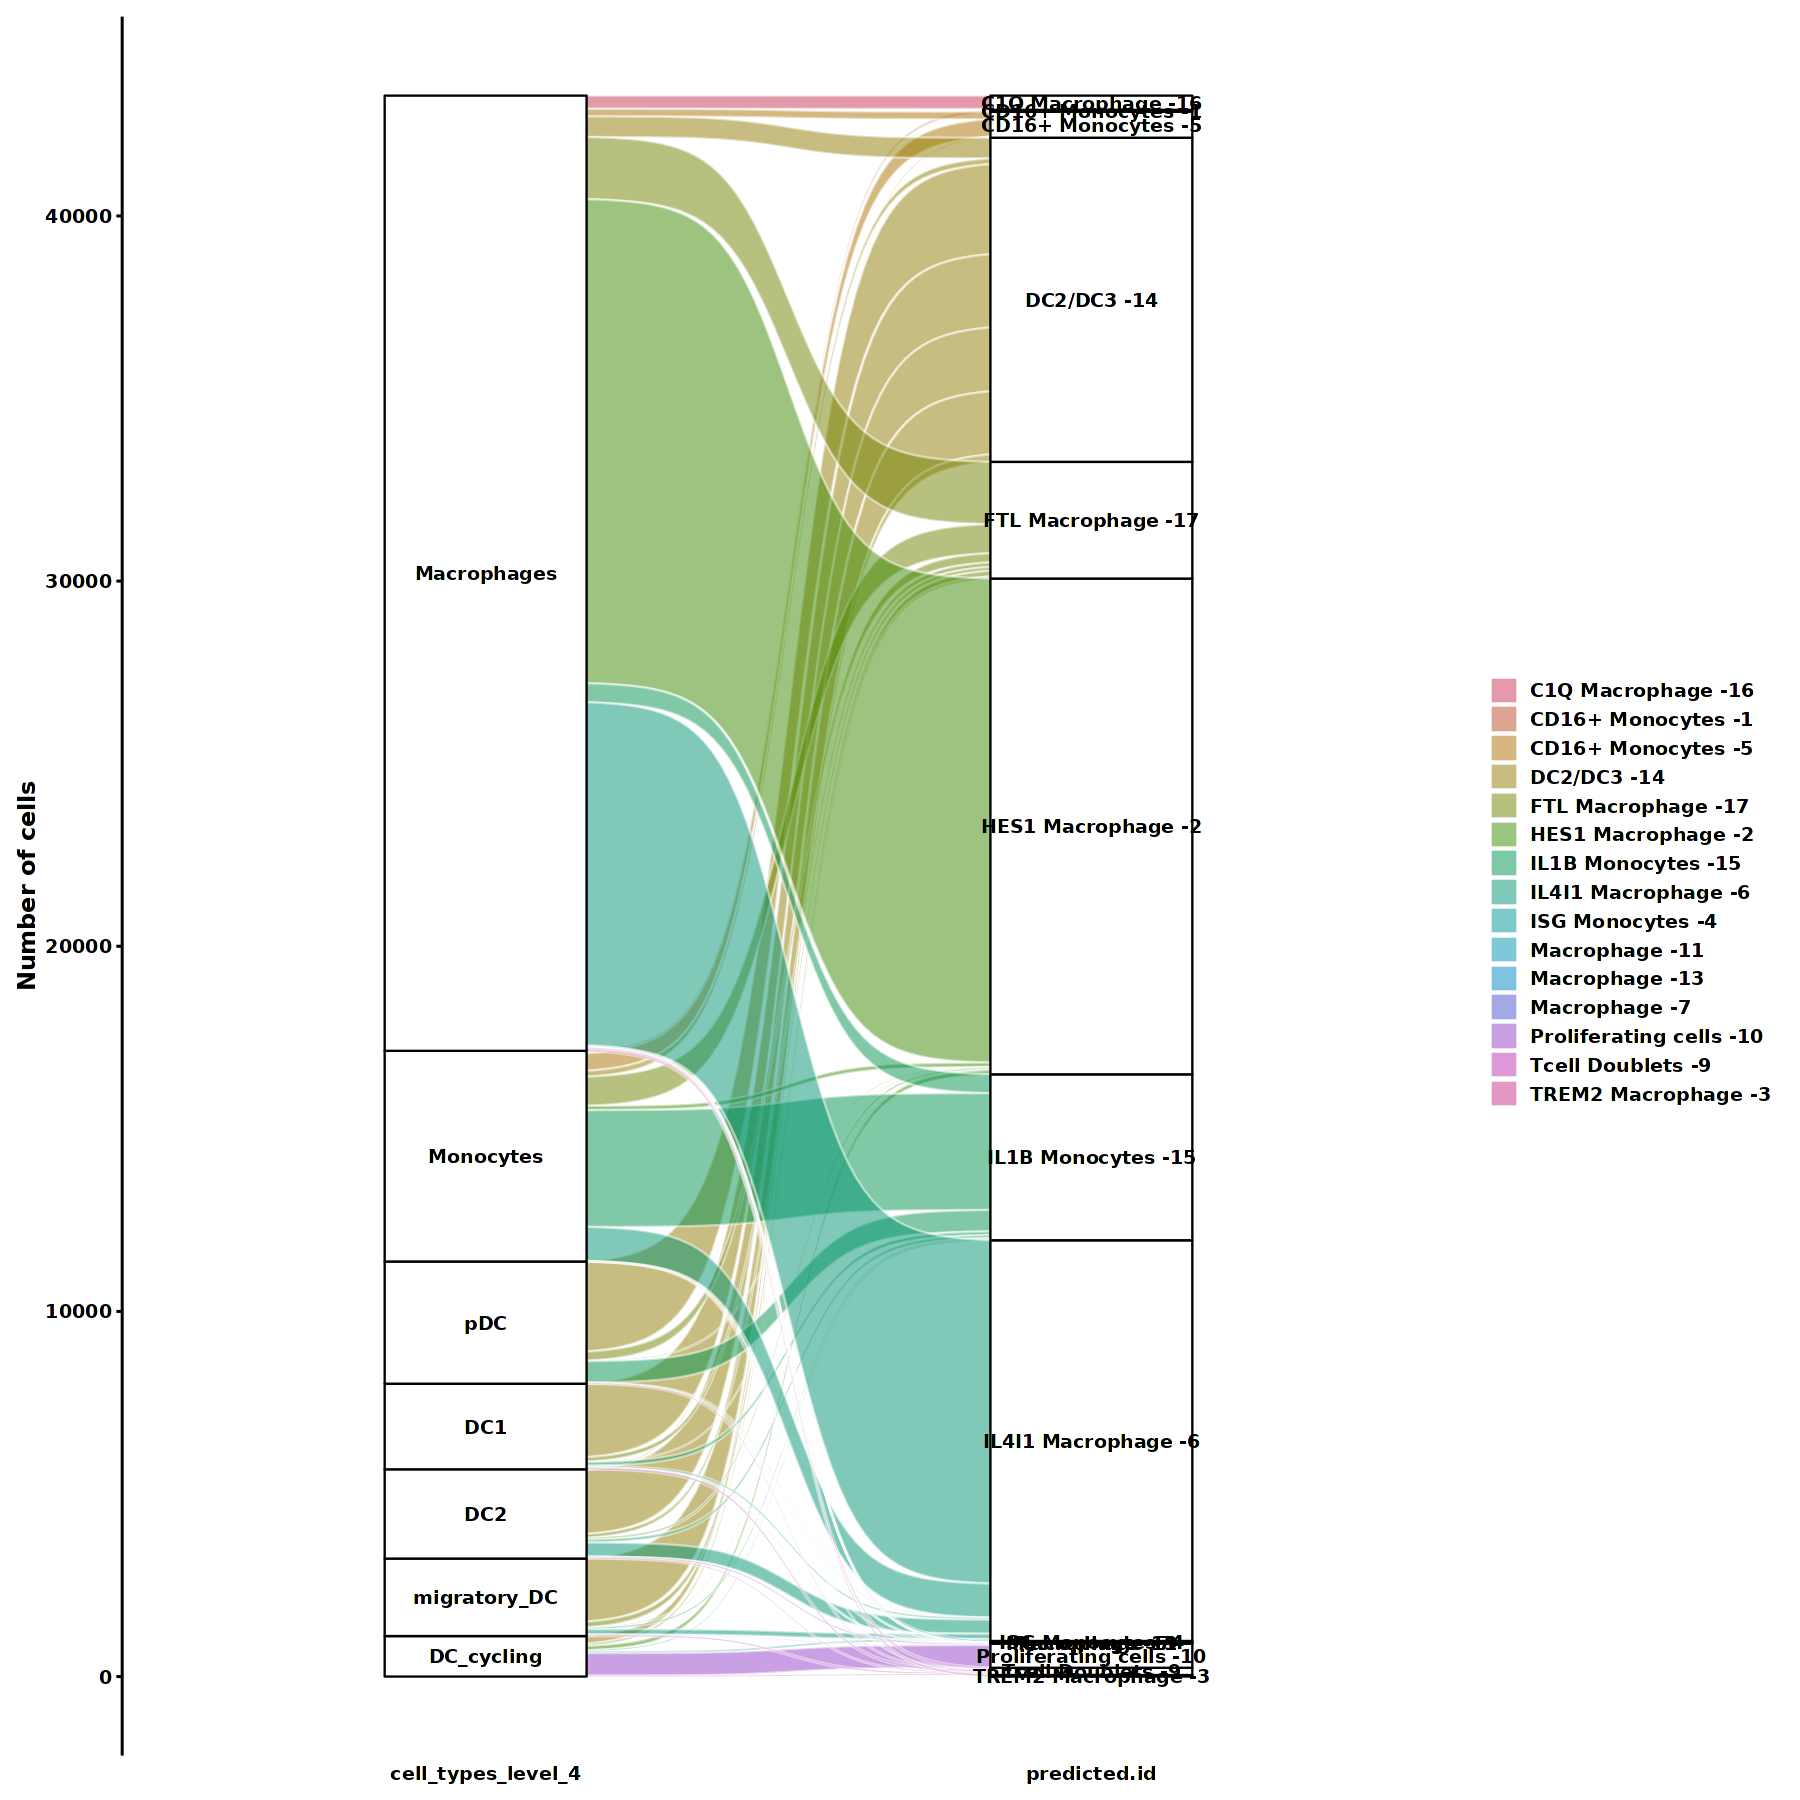

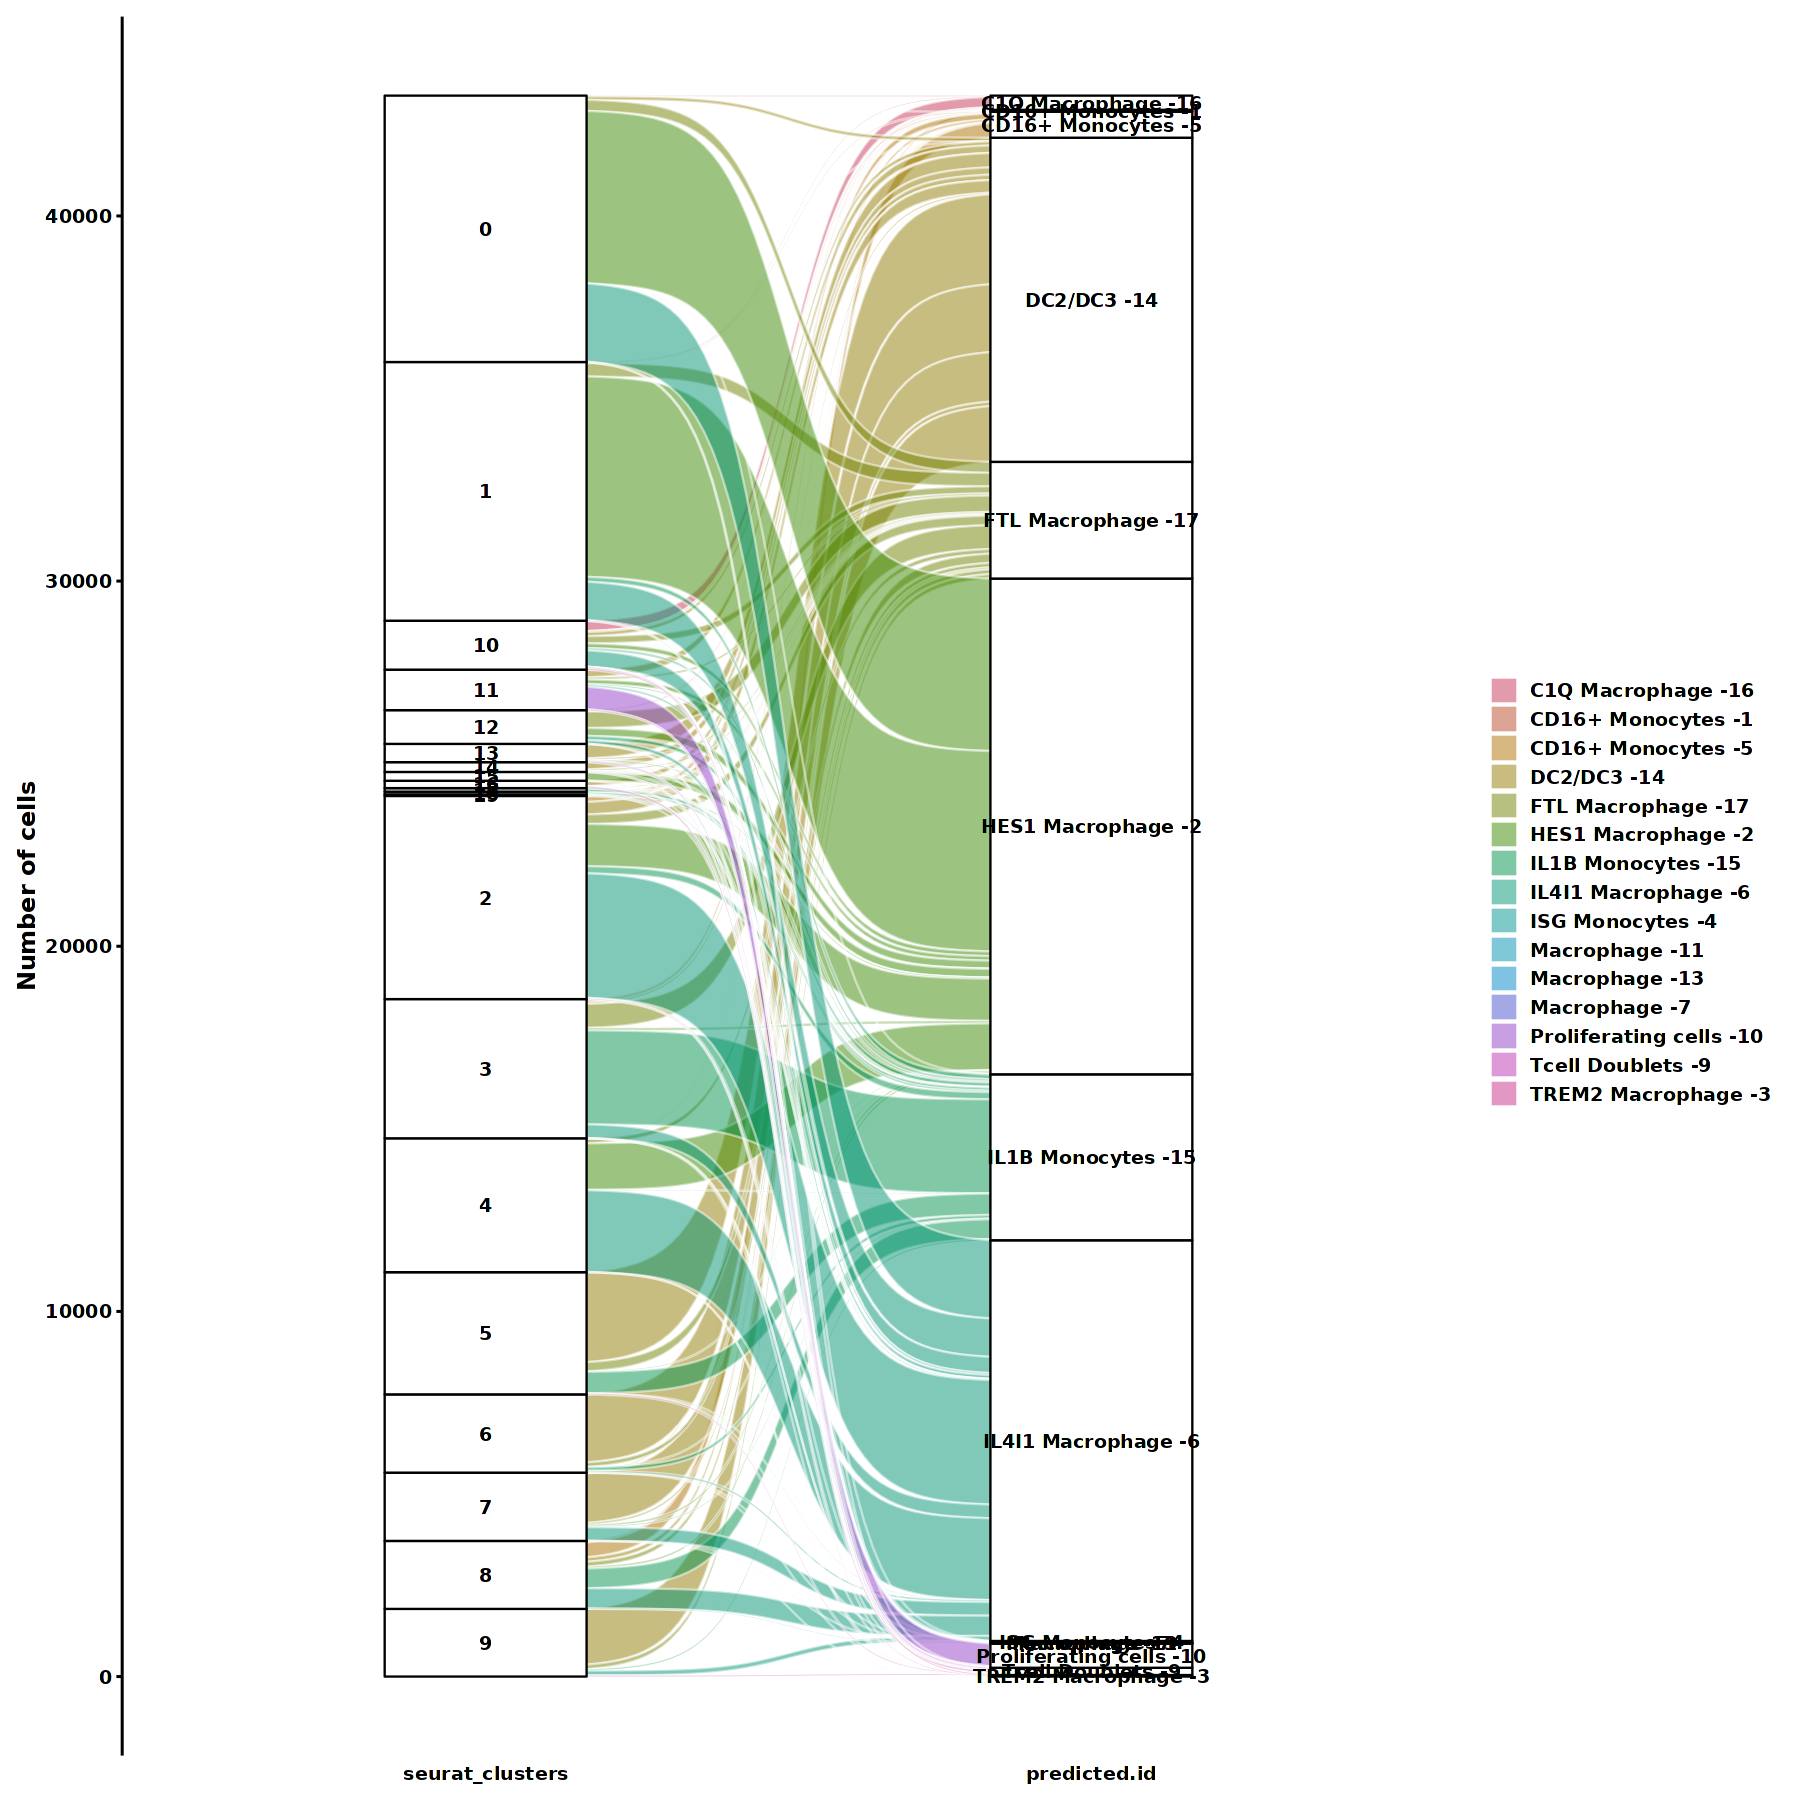

In [42]:
options(repr.plot.width=15, repr.plot.height=15)

SCpubr::do_AlluvialPlot(sample = combined_myeloid_cells,
                            first_group = "seurat_clusters",
                            middle_group = "cell_types_level_4", 
                            last_group = "predicted.id")
SCpubr::do_AlluvialPlot(sample = combined_myeloid_cells,
                            first_group = "cell_types_level_4",
                            last_group = "predicted.id")
SCpubr::do_AlluvialPlot(sample = combined_myeloid_cells,
                            first_group = "seurat_clusters",
                            last_group = "predicted.id")

In [62]:
combined_myeloid_cells <- RenameIdents(object = combined_myeloid_cells, 
                               "0" = "COL19A1_macrophages",
                               "1" = "HES1_like_macrophages",
                               "2" = "IFN_macrophages",
                               "3" = "IL1B_monocytes",
                               "4" = "IFN_macrophages",
                               "5" = "pDC",
                               "6" = "DC1",
                               "7" = "DC2",
                               "8" = "IL1B_monocytes",
                               "9" = "migratory_DC",
                               "10" = "C1Q_FTL_macrophages",
                               "11" = "Proliferating",
                               "12" = "C1Q_FTL_macrophages",
                               "13" = "DC2",
                               "14" = "migratory_DC",
                               "15" = "LN_resident_erythrophagocytic_macrophages", 
                               "16" = "DC1",
                               "17" = "IL1B_monocytes",
                               "18" = "DC2", 
                               "19" = "COL19A1_macrophages"
                           )
#Add metadata column with this information
combined_myeloid_cells$cell_types_level_6 <- combined_myeloid_cells@active.ident


#Set seurat_clusters as default again
combined_myeloid_cells@active.ident <- as.factor(combined_myeloid_cells$seurat_clusters)

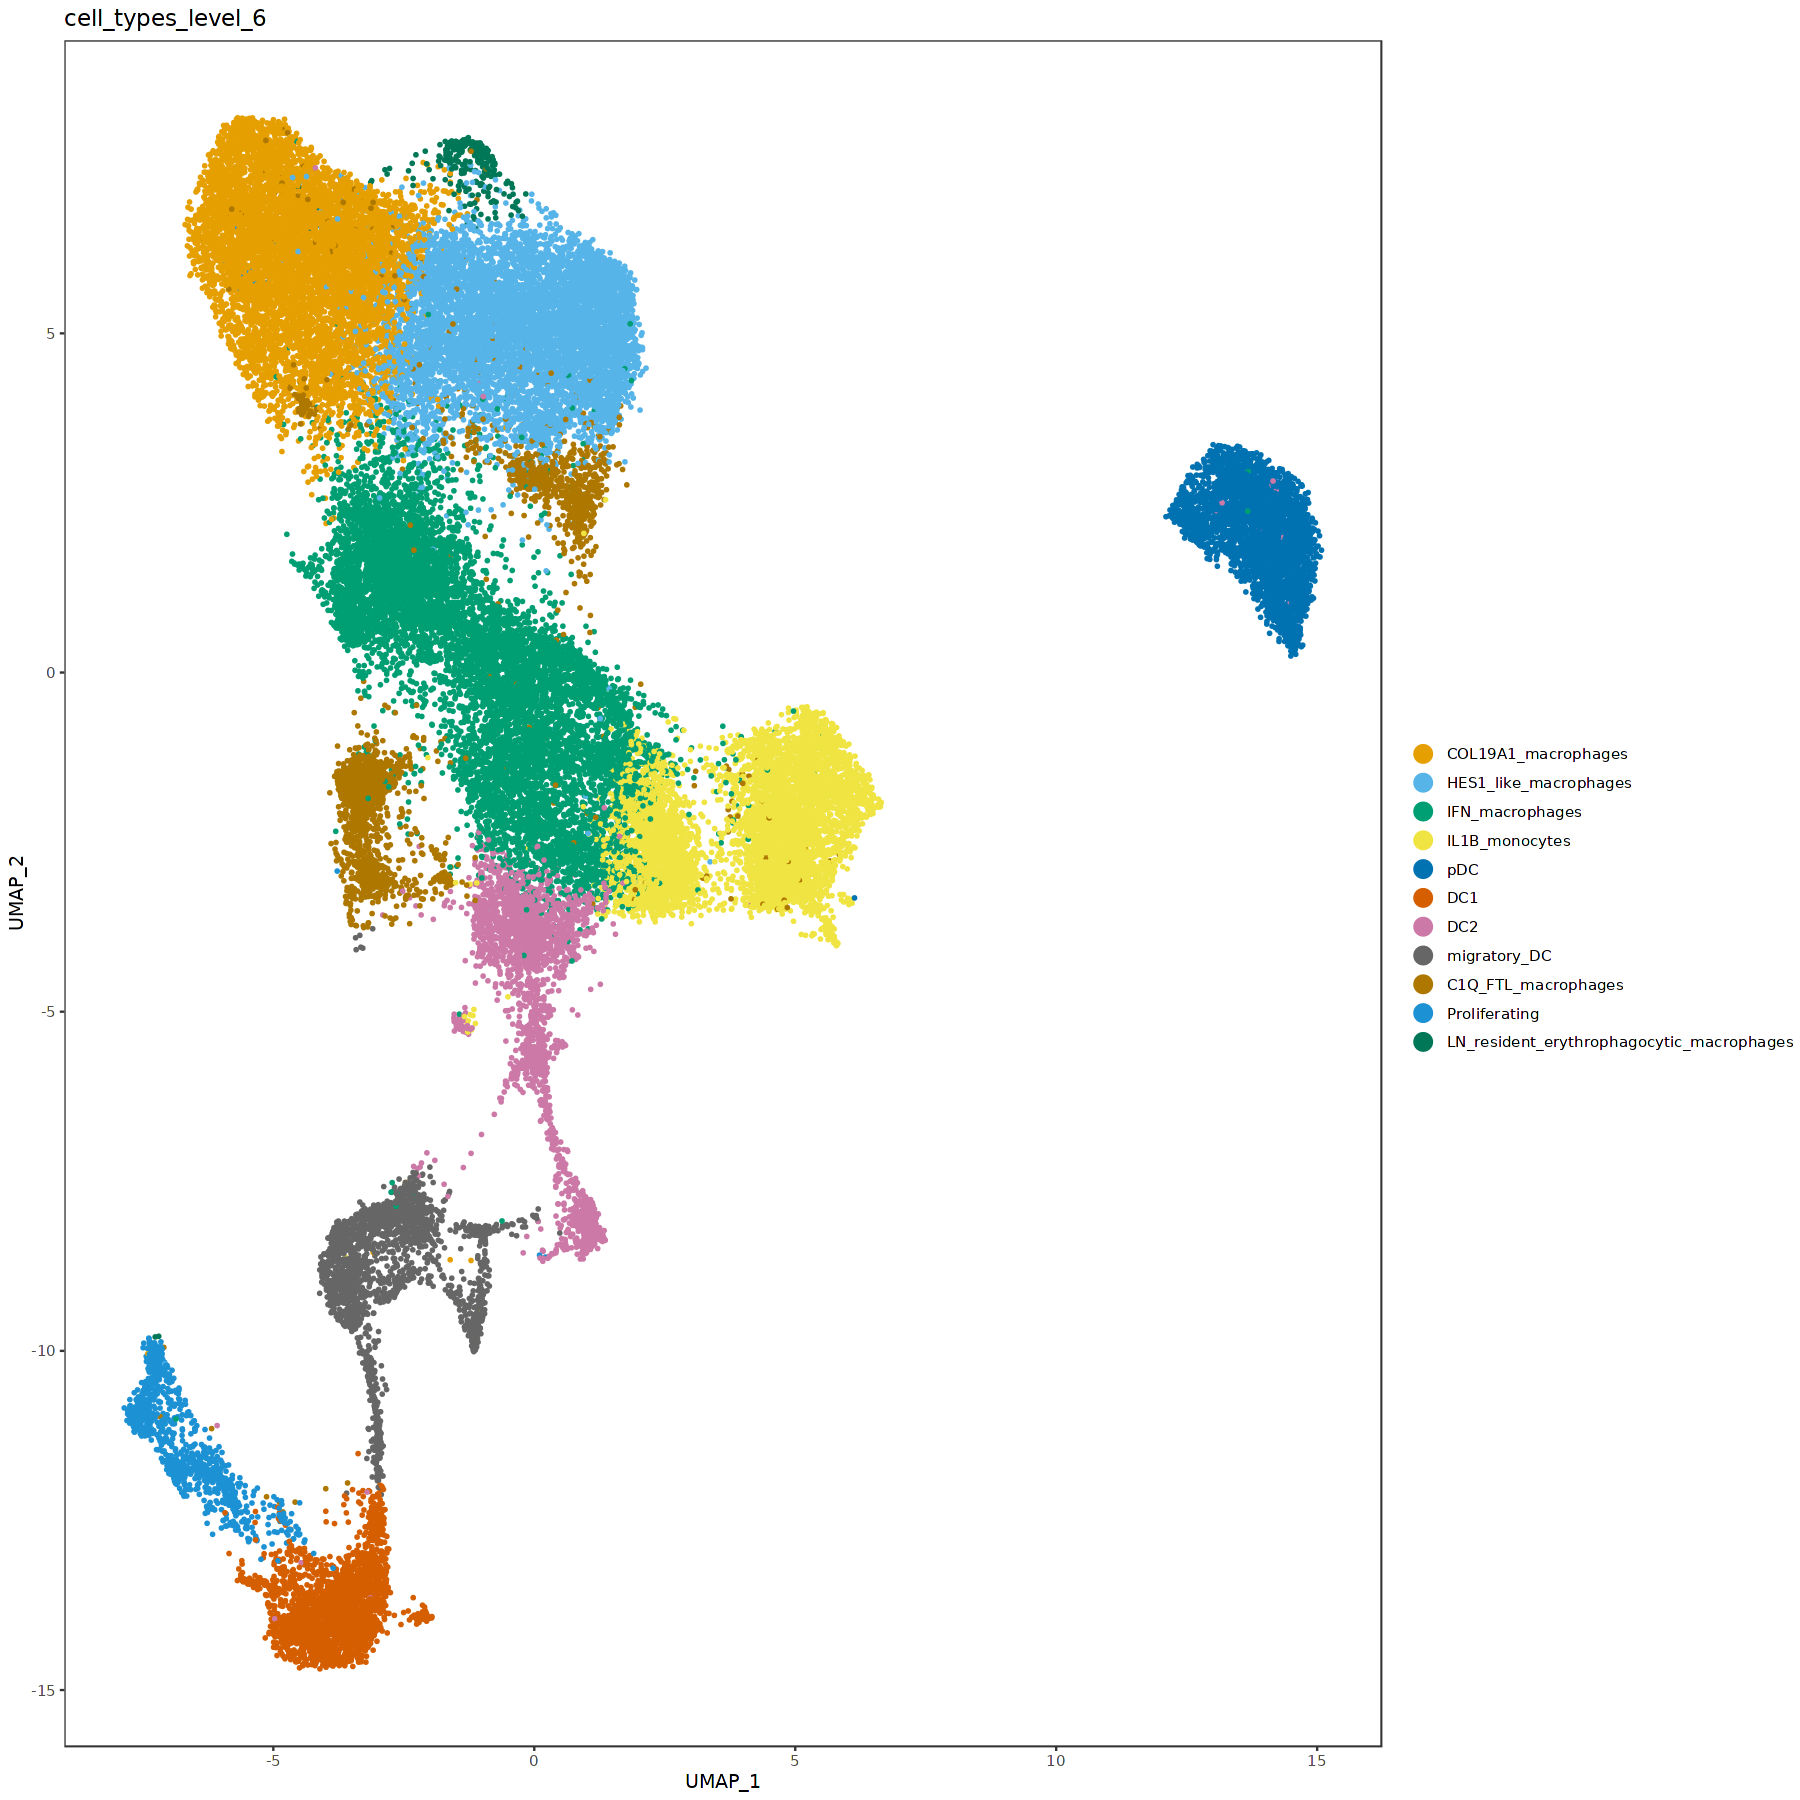

In [63]:
dittoDimPlot(combined_myeloid_cells, var = "cell_types_level_6")


In [67]:
setwd("/home/vshanmug/results/080622_single_nuc_Hodgkin_annotation/")

saveRDS(combined_myeloid_cells, "combined_myeloid_cells_with_label_transfer.rds")

In [11]:
combined_monomac_cells <- subset(combined_myeloid_cells, subset = cell_types_level_4 %in% c("Macrophages", "Monocytes"))                                
combined_monomac_cells <- subset(combined_monomac_cells, subset = predicted.id %in% c("C1Q Macrophage -16", "CD16+ Monocytes", "DC2/DC3 -14", "FTL Macrophage -17", "HES1 Macrophage -2", "IL1B Monocytes -15", "IL4I1 Macrophage -6"))



     C1Q Macrophage -16      CD16+ Monocytes -1      CD16+ Monocytes -5 
                    383                      50                     684 
            DC2/DC3 -14      FTL Macrophage -17      HES1 Macrophage -2 
                    724                    2501                   13374 
     IL1B Monocytes -15     IL4I1 Macrophage -6        ISG Monocytes -4 
                   3716                   10335                      54 
         Macrophage -11          Macrophage -13           Macrophage -7 
                      3                       2                       2 
Proliferating cells -10       Tcell Doublets -9     TREM2 Macrophage -3 
                      7                      52                      42 

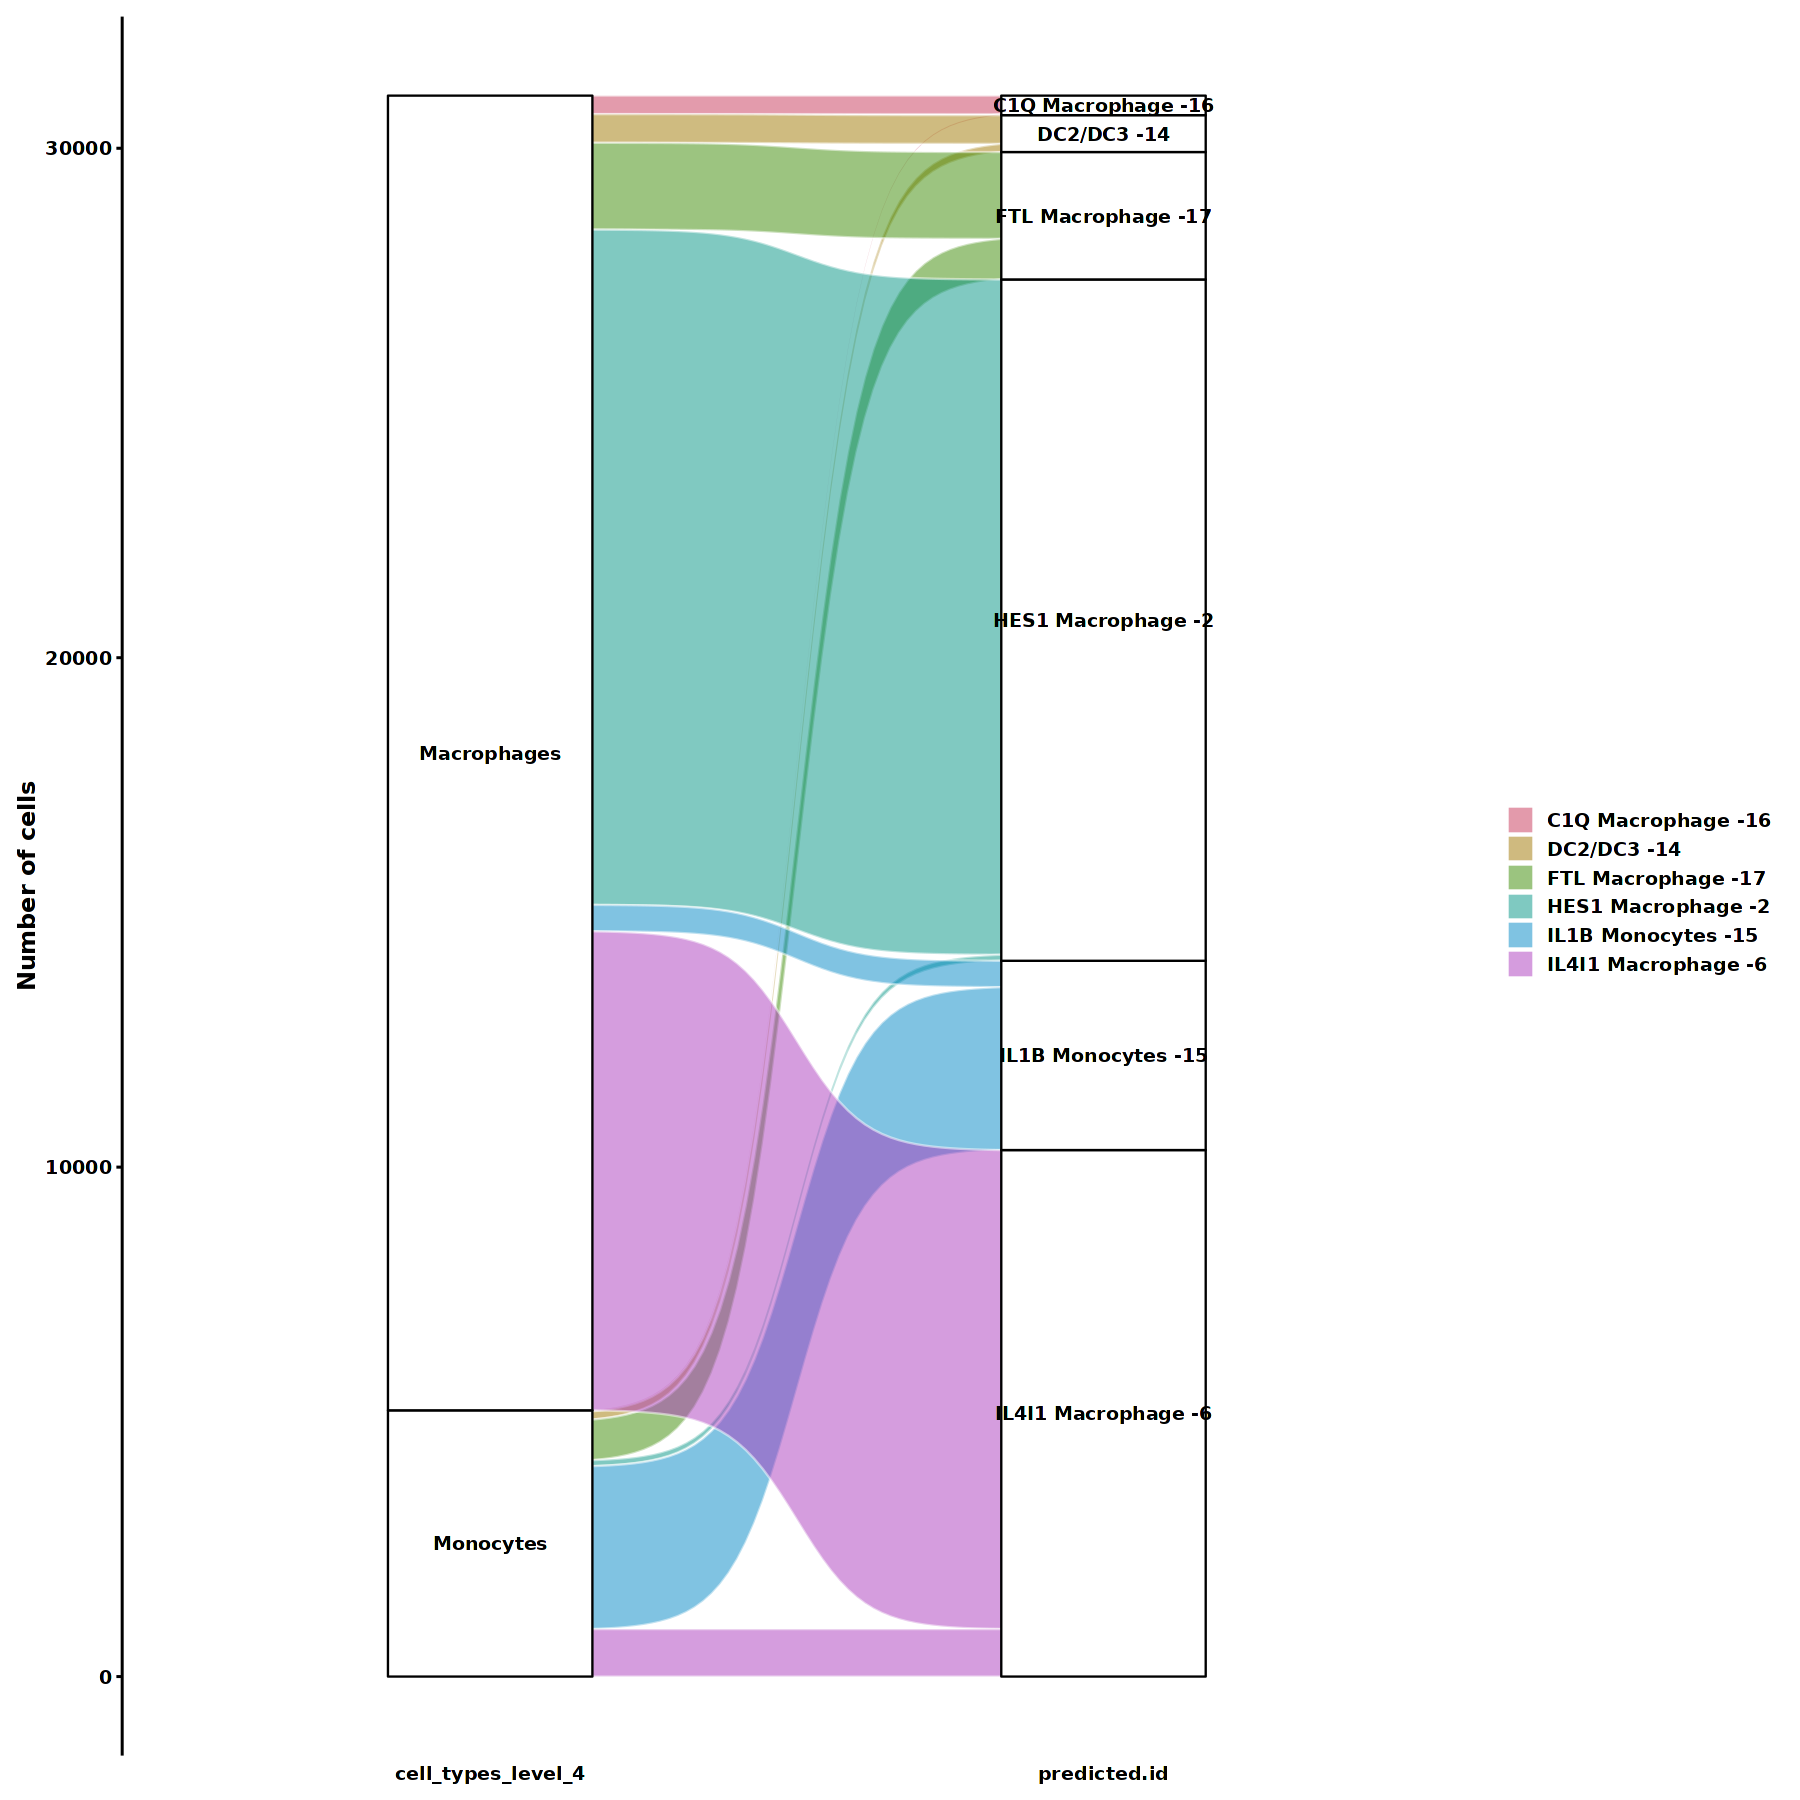

In [16]:
options(repr.plot.width=15, repr.plot.height=15)

SCpubr::do_AlluvialPlot(sample = combined_monomac_cells,
                            first_group = "cell_types_level_4",
                            last_group = "predicted.id")

ggsave("Monomac_mulder_label_transfer_azimuth_alluvial_plot.pdf", width = 10, height = 10)